<a href="https://colab.research.google.com/github/Gonde94/House-Price-Prediction/blob/main/SimpleUNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import shutil
from glob import glob
import random
from tqdm.notebook import tqdm
from PIL import Image
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization 
from keras.layers import Activation, Conv2DTranspose, concatenate, Input, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
!tar -xzvf "/content/drive/MyDrive/Diss_Dataset.tar.gz" 

Streaming output truncated to the last 5000 lines.
Diss_Dataset/target/train/265two_rec_true.tiff
Diss_Dataset/target/validation/514two_obj_true.tiff
Diss_Dataset/target/train/278one_rec_true.tiff
Diss_Dataset/input/train/69two_obj_app_res.tiff
Diss_Dataset/target/train/202three_ell_true.tiff
Diss_Dataset/input/train/85one_ell_app_res.tiff
Diss_Dataset/input/train/460one_rec_app_res.tiff
Diss_Dataset/input/train/245one_rec_app_res.tiff
Diss_Dataset/target/test/574two_obj_true.tiff
Diss_Dataset/input/train/57one_rec_app_res.tiff
Diss_Dataset/target/train/431two_ell_true.tiff
Diss_Dataset/target/train/1346one_ell_true.tiff
Diss_Dataset/input/train/695one_ell_app_res.tiff
Diss_Dataset/target/train/444one_ell_true.tiff
Diss_Dataset/target/train/248one_rec_true.tiff
Diss_Dataset/input/train/380three_rec_app_res.tiff
Diss_Dataset/input/train/369two_obj_app_res.tiff
Diss_Dataset/target/test/495three_ell_true.tiff
Diss_Dataset/input/train/385one_ell_app_res.tiff
Diss_Dataset/input/train/72one_

In [43]:
#Confirm the size of each split

dirr = "/content/Diss_Dataset/"

print('Total input train images: ', len(os.listdir(dirr+"input/train")))
print('Total input validation images: ', len(os.listdir(dirr+"input/validation")))
print('Total input test images: ', len(os.listdir(dirr+"input/test")))
print('Total target train images: ', len(os.listdir(dirr+"target/train")))
print('Total target validation images: ', len(os.listdir(dirr+"target/validation")))
print('Total target test images: ', len(os.listdir(dirr+"target/test")))

Total input train images:  4100
Total input validation images:  400
Total input test images:  400
Total target train images:  4100
Total target validation images:  400
Total target test images:  400


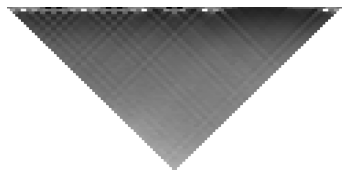

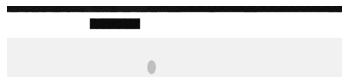

In [49]:
#What does one image and corresponding target look like?

img = imread(input_img_paths[1000])
plt.imshow(img)
plt.axis('off')
plt.show()

tar = imread(target_img_paths[1000])
plt.imshow(tar)
plt.axis('off')
plt.show()

In [51]:
#Load the inputs and targets into arrays

im_width = 128
im_height = 128

train_ids = next(os.walk(dirr+"input/train"))[2]
tar_ids = next(os.walk(dirr+"target/train"))[2]

In [52]:
X = np.zeros((len(train_ids), im_width, im_height, 1), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)

print(X.shape)
print(y.shape)

(4100, 128, 128, 1)
(4100, 128, 128, 1)


In [55]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    #Load images
    img = load_img(dirr + "input/train/" + id_)
    x_img = img_to_array(img)[:,:,1]
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    #Normalise images
    X[n] = x_img/255.0
    
for n, id_ in tqdm(enumerate(tar_ids), total=len(tar_ids)):
    #Load targets
    mask = img_to_array(load_img(dirr + "target/train/" + id_))[:,:,1]
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
    
    #Normalise images
    y[n] = mask/255.0

  0%|          | 0/4100 [00:00<?, ?it/s]

  0%|          | 0/4100 [00:00<?, ?it/s]

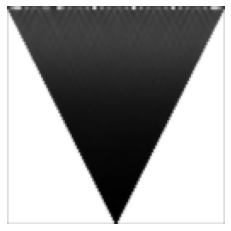

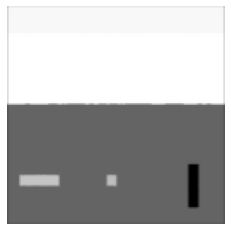

In [57]:
#Check if training data looks okay

ix = 1000
plt.imshow(np.dstack((X[ix], X[ix], X[ix])))
plt.axis('off')
plt.show()

tmp = np.squeeze(y[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.axis('off')
plt.show()

In [58]:
X[1000]

array([[[0.20419002],
        [0.26494476],
        [0.47285002],
        ...,
        [0.4781247 ],
        [0.26252434],
        [0.2011458 ]],

       [[0.26185942],
        [0.29902935],
        [0.50967485],
        ...,
        [0.51545936],
        [0.2967044 ],
        [0.2587032 ]],

       [[0.68256843],
        [0.34191415],
        [0.28984112],
        ...,
        [0.29439706],
        [0.34422058],
        [0.6823716 ]],

       ...,

       [[0.8667242 ],
        [0.99962366],
        [1.        ],
        ...,
        [1.        ],
        [0.99962366],
        [0.8667242 ]],

       [[0.8666585 ],
        [0.999548  ],
        [0.9999243 ],
        ...,
        [0.9999243 ],
        [0.99954796],
        [0.86665857]],

       [[0.77689344],
        [0.8960187 ],
        [0.89635605],
        ...,
        [0.89635605],
        [0.8960187 ],
        [0.7768934 ]]], dtype=float32)

In [59]:
y[1000]

array([[[0.7942322 ],
        [0.91601616],
        [0.916361  ],
        ...,
        [0.916361  ],
        [0.91601616],
        [0.7942322 ]],

       [[0.8429317 ],
        [0.97218305],
        [0.972549  ],
        ...,
        [0.972549  ],
        [0.97218305],
        [0.84293175]],

       [[0.8429317 ],
        [0.97218305],
        [0.972549  ],
        ...,
        [0.972549  ],
        [0.97218305],
        [0.84293175]],

       ...,

       [[0.33989182],
        [0.3920093 ],
        [0.39215687],
        ...,
        [0.39215687],
        [0.3920093 ],
        [0.33989182]],

       [[0.33989182],
        [0.3920093 ],
        [0.39215687],
        ...,
        [0.39215687],
        [0.3920093 ],
        [0.33989182]],

       [[0.3202549 ],
        [0.36936134],
        [0.36950037],
        ...,
        [0.36950037],
        [0.36936134],
        [0.3202549 ]]], dtype=float32)

In [60]:
print(X[1000].shape)
print(y[1000].shape)

(128, 128, 1)
(128, 128, 1)


In [61]:
#Define metric - Intersection over Union (IoU)

def IoU(y_pred, y_true):
    I = tf.reduce_sum(y_pred * y_true, axis=(1,2))
    U = tf.reduce_sum(y_pred + y_true, axis=(1,2)) - I
    return tf.reduce_mean(I / U)

In [67]:
#Get validation data

val_train_ids = next(os.walk(dirr+"input/validation/"))[2]
val_tar_ids = next(os.walk(dirr+"target/validation/"))[2]

In [68]:
X_val = np.zeros((len(val_train_ids), im_height, im_width, 1), dtype=np.float32)
y_val = np.zeros((len(val_tar_ids), im_height, im_width, 1), dtype=np.float32)

In [70]:
for n, id_ in tqdm(enumerate(val_train_ids), total=len(val_train_ids)):
    #Load images
    img = load_img(dirr + "input/validation/" + id_)
    x_img = img_to_array(img)[:,:,1]
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    #Normalise images
    X_val[n] = x_img/255.0
    
for n, id_ in tqdm(enumerate(val_tar_ids), total=len(val_tar_ids)):
    #Load targets
    mask = img_to_array(load_img(dirr + "target/validation/" + id_))[:,:,1]
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
    
    #Normalise images
    y_val[n] = mask/255.0

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [71]:
#Simple UNET for semantic segmentation

def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((128, 128, 1))
output_layer = build_model(input_layer, 16)

In [72]:
model = Model(input_layer, output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[IoU])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [74]:
#Train the model

early_stopping = EarlyStopping(patience=2, verbose=1)
model_checkpoint = ModelCheckpoint("FindObjectsMeanIou.h5", save_best_only=True, verbose=1)

epochs = 15
batch_size = 32

history = model.fit(X, y, validation_data=[X_val, y_val], epochs=epochs, batch_size=batch_size,
                   callbacks=[early_stopping, model_checkpoint])

Epoch 1/15
129/129 [==============================] - ETA: 0s - loss: 0.6932 - IoU: 0.3076
Epoch 1: val_loss improved from inf to 0.69321, saving model to FindObjectsMeanIou.h5
129/129 [==============================] - 607s 5s/step - loss: 0.6932 - IoU: 0.3076 - val_loss: 0.6932 - val_IoU: 0.3116
Epoch 2/15
129/129 [==============================] - ETA: 0s - loss: 0.6930 - IoU: 0.3053
Epoch 2: val_loss improved from 0.69321 to 0.69311, saving model to FindObjectsMeanIou.h5
129/129 [==============================] - 616s 5s/step - loss: 0.6930 - IoU: 0.3053 - val_loss: 0.6931 - val_IoU: 0.3121
Epoch 3/15
129/129 [==============================] - ETA: 0s - loss: 0.6930 - IoU: 0.3073
Epoch 3: val_loss did not improve from 0.69311
129/129 [==============================] - 590s 5s/step - loss: 0.6930 - IoU: 0.3073 - val_loss: 0.6932 - val_IoU: 0.3111
Epoch 4/15
129/129 [==============================] - ETA: 0s - loss: 0.6930 - IoU: 0.3072
Epoch 4: val_loss did not improve from 0.69311


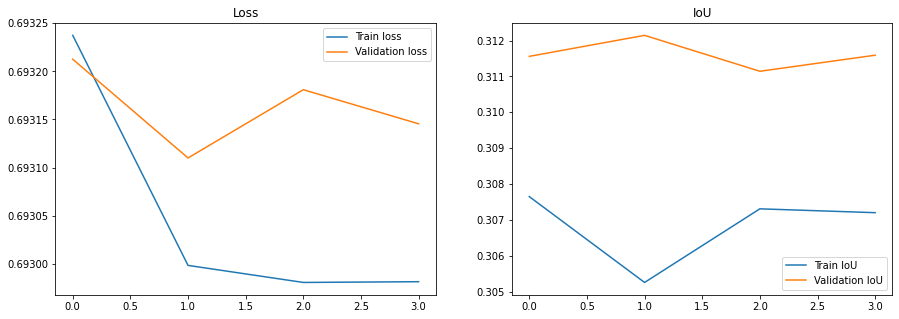

In [87]:
fig, (ax_loss, ax_iou) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.set_title('Loss')
ax_loss.legend()


ax_iou.plot(history.epoch, history.history["IoU"], label="Train IoU")
ax_iou.plot(history.epoch, history.history["val_IoU"], label="Validation IoU")
ax_iou.set_title('IoU')
ax_iou.legend()

# New section

In [80]:
#Predict the validation set to do a sanity check

model = load_model("/content/FindObjectsMeanIou.h5", custom_objects={"IoU": IoU})

In [81]:
preds_train = model.predict(X, verbose=1)
preds_valid = model.predict(X_val, verbose=1)

13/13 [==============================] - 12s 954ms/step


In [82]:
#Threshold predictions

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_valid_t = (preds_valid > 0.5).astype(np.uint8)

In [83]:
#Function to visualise some predictions

def plot_sample(X, y, preds, ix=None):
    """Function to plot the results"""
    ix = random.randint(0, len(X))
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix,...,0])
    ax[0].set_title('Apparent Resistivity')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('True Model')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted model')

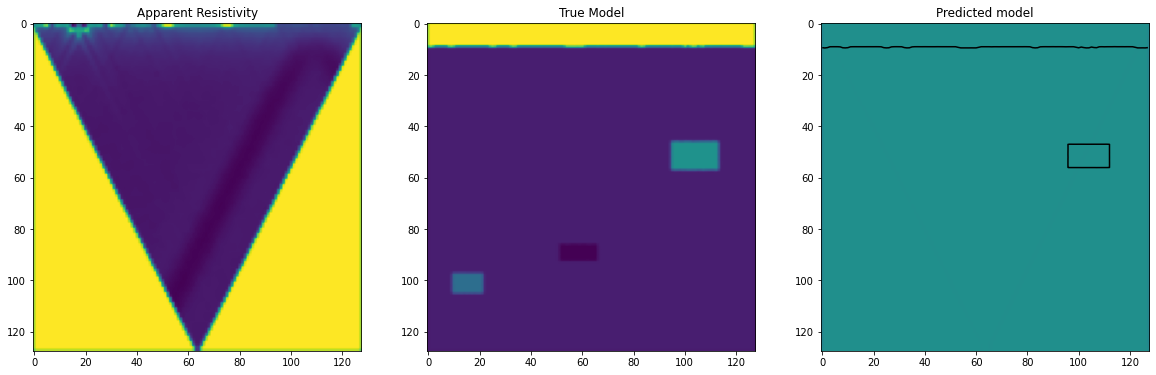

In [84]:
#Predictions on training set
plot_sample(X, y, preds_train)

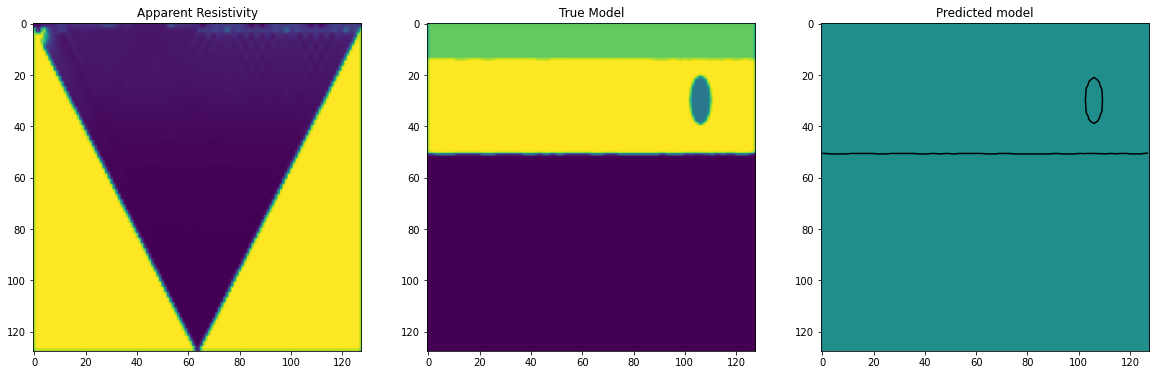

In [85]:
#Predictions on validation set
plot_sample(X_val, y_val, preds_valid)